<a href="https://colab.research.google.com/github/HSE-LAMBDA/MLDM-2022/blob/master/12-architectures/TL_AE_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [133]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs, getcwd, remove
from os.path import isfile, join, abspath, exists, isdir, expanduser
from PIL import Image
import torch
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms, datasets, models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import copy
import torch.nn.functional as F
from mpl_toolkits.axes_grid1 import AxesGrid


In [2]:
np.random.seed(1337)

# Dog Breed Identification




Download the dataset from [Dog Breed Identification
 Competition](https://www.kaggle.com/competitions/dog-breed-identification/data)

Let's use 64 most frequent breeds to simplify the task.

In [3]:
INPUT_SIZE = 224
NUM_CLASSES = 64
data_dir = 'content/data/'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))

10222 10222
10357 10357


In [4]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot(index='id', columns='breed', values='target').reset_index().fillna(0)

train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]
print(train.shape, valid.shape)

(4838, 65) (1210, 65)


Custom dataset is going to be useful for our needs.

In [49]:
class DogsDataset(Dataset):
    def __init__(self, labels, root_dir, subset=False, transform=None):
        self.labels = labels
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img_name = '{}.jpg'.format(self.labels.iloc[idx, 0])
        fullname = join(self.root_dir, img_name)
        image = Image.open(fullname)
        labels = self.labels.iloc[idx, 1:].to_numpy().astype('float')
        labels = np.argmax(labels)
        if self.transform:
            image = self.transform(image)
        return [image, labels]

In [6]:
normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(224),
                               transforms.CenterCrop(224),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)

# Я УБИЛ ПОЛЧАСА ПЫТАСЯСЬ ПОНЯТЬ В ЧЁМ ПРОБЛЕМА, НЕУЖЕЛИ НИКТО ЭТО НЕ ТЕСТИЛ НЕ В КОЛЛАБЕ (num_workers)

In [7]:
def imshow(axis, inp):
    """Denormalize and show"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    axis.imshow(inp)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 224, 224]) torch.Size([4])


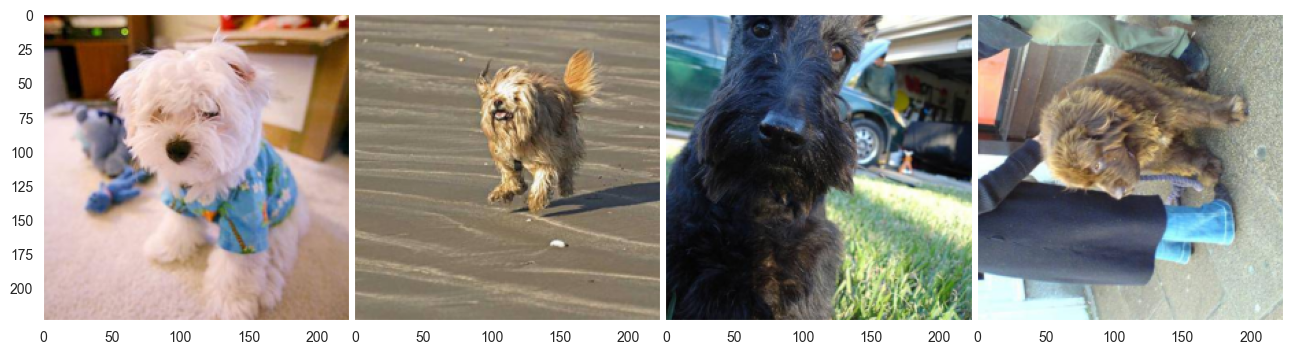

In [8]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])
    ax.grid(False)

# Task 1: Transfer Learning (2 points)



Pick up some pretrained model, e.g. resnet 50 and tune it for our needs.

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet = models.resnet50(pretrained=True)
inputs, labels = next(iter(train_dl))
resnet = resnet.to(device)
inputs, labels = inputs.to(device), labels.to(device)
outputs = resnet(inputs)
outputs.size()

C:\PYTHON\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\PYTHON\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


torch.Size([4, 1000])

In [11]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

This models provides us with 1000 values, representing the classes which ResNet was trained on.

Replace last layer with one that predicts the 64 classes.
The network weights should be fixed expected for the last layer that is trained.

In [71]:
def train_model(dataloaders, model, criterion, optimizer, scheduler, num_epochs=1):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print("-" * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    # print(outputs.requires_grad)
                    # print(preds.requires_grad)
                    # print(labels.requires_grad)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    model.load_state_dict(best_model_wts)
    return model

In [72]:
resnet = models.resnet50(pretrained=True)
# freeze all model parameters
for param in resnet.parameters():
    param.requires_grad = False

# add new layer
# hint: you can get the number of features
# using in_features, e.g resnet.fc.in_features

lr = 1e-2
epochs = 10

resnet.fc = nn.Linear(2048, 64)

resnet = resnet.cuda()

for param in resnet.fc.parameters():
    param.requires_grad = True

optimizer = optim.Adam(resnet.parameters(), lr=lr)

# criterion = nn.MSELoss()
criterion = nn.CrossEntropyLoss()

scheduler =  lr_scheduler.StepLR(optimizer, step_size=75, gamma=0.1)

dloaders = {'train':train_dl, 'val':valid_dl}

C:\PYTHON\Python\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\PYTHON\Python\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [73]:
model = train_model(dloaders, resnet, criterion, optimizer, scheduler, num_epochs=epochs)

Epoch 1/10
----------
Train Loss: 11.2831 Acc: 0.3421
Val Loss: 3.6987 Acc: 0.7744

Epoch 2/10
----------
Train Loss: 8.7084 Acc: 0.5426
Val Loss: 5.0246 Acc: 0.7868

Epoch 3/10
----------
Train Loss: 8.7015 Acc: 0.6019
Val Loss: 3.5932 Acc: 0.8306

Epoch 4/10
----------
Train Loss: 9.2328 Acc: 0.6267
Val Loss: 4.4788 Acc: 0.8455

Epoch 5/10
----------
Train Loss: 8.1294 Acc: 0.6656
Val Loss: 6.8057 Acc: 0.7884

Epoch 6/10
----------
Train Loss: 8.4481 Acc: 0.6635
Val Loss: 4.1272 Acc: 0.8537

Epoch 7/10
----------
Train Loss: 8.7199 Acc: 0.6800
Val Loss: 4.5429 Acc: 0.8413

Epoch 8/10
----------
Train Loss: 8.1437 Acc: 0.7073
Val Loss: 5.9457 Acc: 0.8355

Epoch 9/10
----------
Train Loss: 8.1807 Acc: 0.7137
Val Loss: 5.7849 Acc: 0.8579

Epoch 10/10
----------
Train Loss: 8.5110 Acc: 0.7181
Val Loss: 6.5017 Acc: 0.8430



In [76]:
def visualize_model(dataloders, model, num_images=16):
    cnt = 0
    fig = plt.figure(1, figsize=(16, 16))
    grid = ImageGrid(fig, 111, nrows_ncols=(4, 4), axes_pad=0.05)
    for i, (inputs, labels) in enumerate(dataloders['val']):
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            ax = grid[cnt]
            imshow(ax, inputs.cpu().data[j])
            ax.text(10, 210, ' Prediction: {}\n Real Label: {}'.format(preds[j], labels.data[j]),
                    color='k', backgroundcolor='w', alpha=0.8)
            cnt += 1
            if cnt == num_images:
                return

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

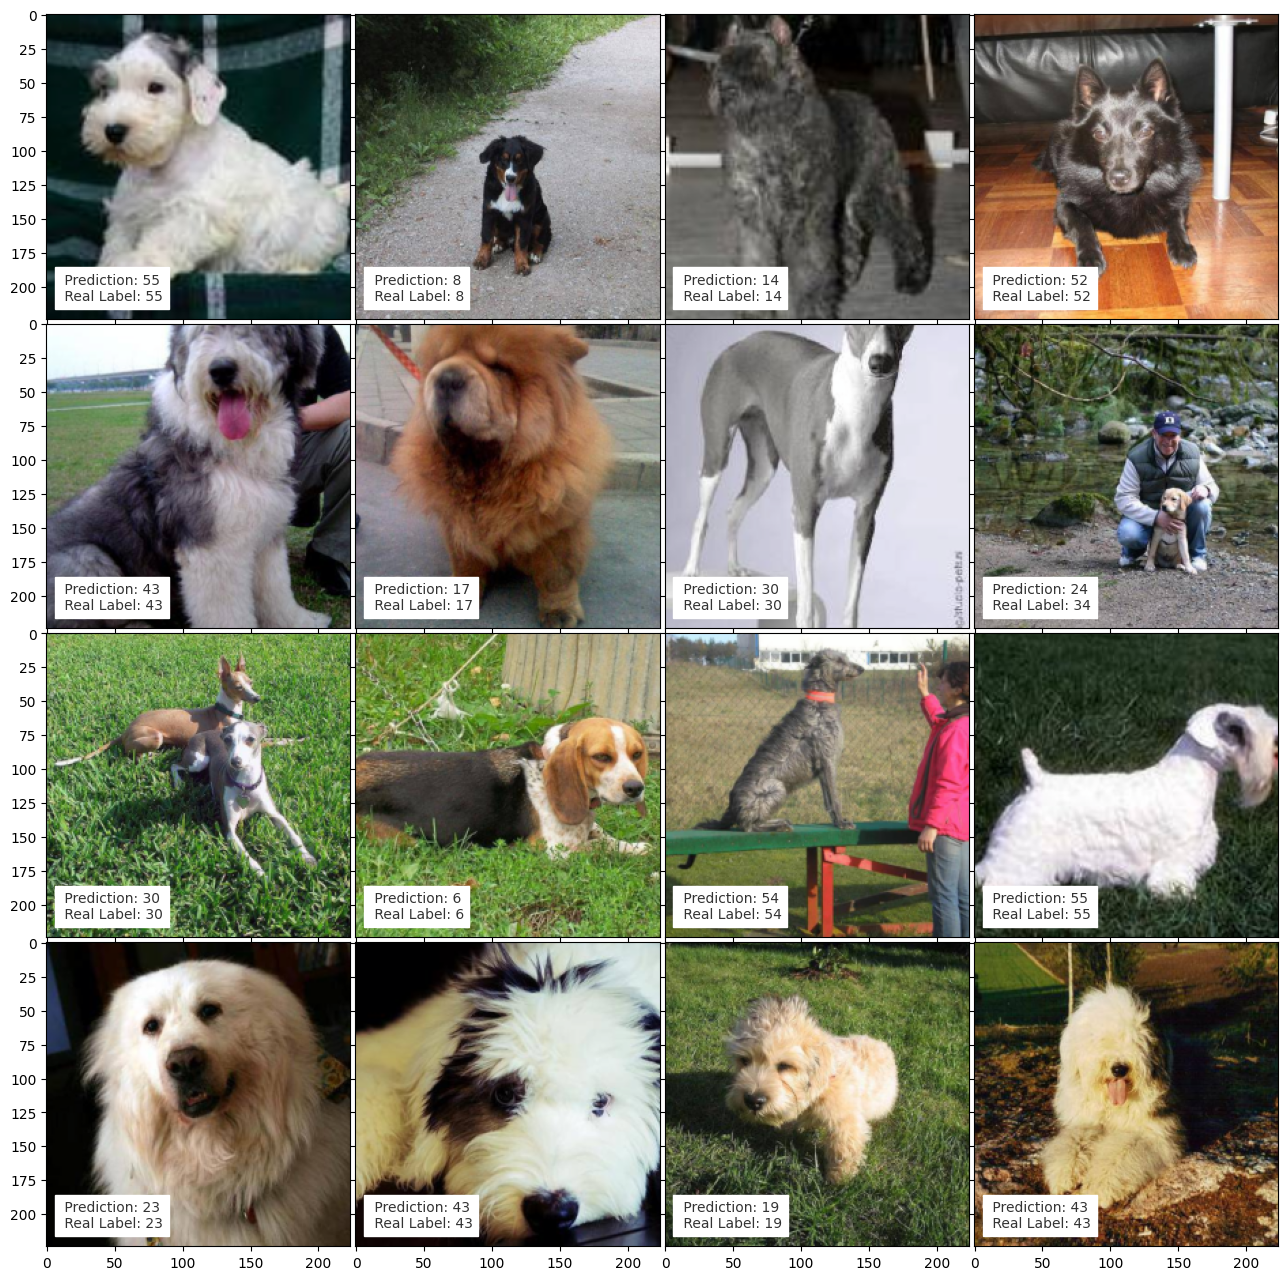

In [77]:
visualize_model(dloaders, resnet)

# Task 2: Low-dimensional dogs (4 points)
Train a **Conditional CNN Autoencoder** that takes class labels into account. Show examples of interpolations between instances of different classes in a latent space and related representation of images in original space (just the same way we did it during practical session).

In [51]:
train = labels_pivot.sample(frac=0.8)
valid = labels_pivot[~labels_pivot['id'].isin(train['id'])]

normalize = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)
ds_trans = transforms.Compose([transforms.Resize(56),
                               transforms.CenterCrop(56),
                               transforms.ToTensor(),
                               normalize])
train_ds = DogsDataset(train, data_dir + 'train/', transform=ds_trans)
valid_ds = DogsDataset(valid, data_dir + 'train/', transform=ds_trans)

train_dl = DataLoader(train_ds, batch_size=4, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=4, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 56, 56]) torch.Size([4])


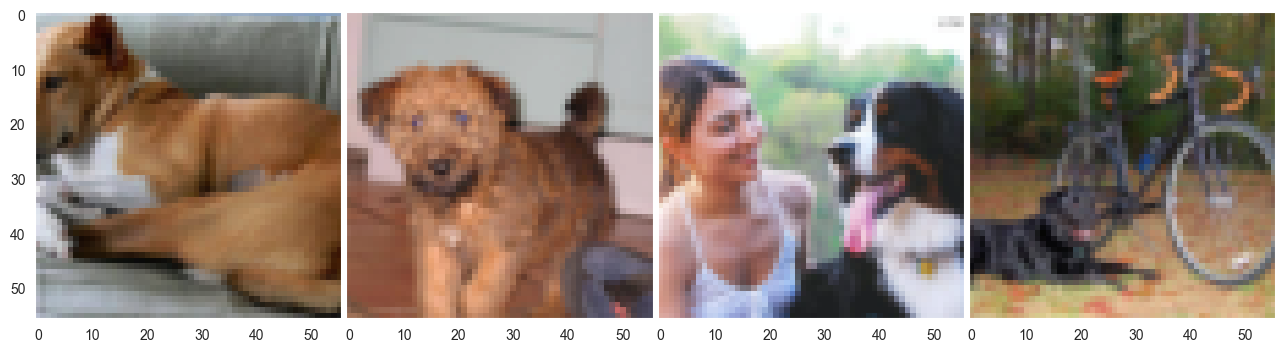

In [23]:
img, label = next(iter(train_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(1, 4), axes_pad=0.05)
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])
    ax.grid(False)

In [68]:
64*14*14

12544

In [66]:
3*224*224

150528

In [119]:
class ConditionalAutoencoder(nn.Module):
    def __init__(self, num_classes):
        super(ConditionalAutoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            # nn.ReLU(),
            # nn.MaxPool2d(kernel_size=2, stride=2),

        )

        self.flatten = nn.Flatten()

        self.label_fc = nn.Linear(num_classes, 64)
        self.sigmoid = nn.Sigmoid()
        self.decoder = nn.Sequential(
            nn.Linear(32 * 7 * 7 + 64, 7 * 7 * 32),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            # nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            # nn.ReLU(),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x, labels):
        # Encode
        x = self.encoder(x)
        # print(x.shape)
        x = self.flatten(x)
        # print(x.shape)
        # Concatenate with labels
        label_embedding = self.label_fc(labels)
        x = torch.cat((x, label_embedding), dim=1)
        x = self.sigmoid(x)
        # Decode
        x = self.decoder(x)
        # print(x.shape)
        # print(x.shape)
        return x

In [114]:
# class ConditionalAutoencoder(nn.Module):
#     def __init__(self, num_classes):
#         super(ConditionalAutoencoder, self).__init__()
#         # Encoder
#         self.enc_conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=2, padding=1)
#         self.enc_conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1)
#         self.enc_fc1 = nn.Linear(32 * 14 * 14 + num_classes, 128)
#         # Decoder
#         self.dec_fc1 = nn.Linear(128 + num_classes, 32 * 14 * 14)
#         self.dec_conv1 = nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1)
#         self.dec_conv2 = nn.ConvTranspose2d(16, 3, kernel_size=3, stride=2, padding=1, output_padding=1)
#     def encode(self, x, labels):
#         x = F.relu(self.enc_conv1(x))
#         x = F.relu(self.enc_conv2(x))
#         x = torch.flatten(x, start_dim=1)
#         labels = labels.view(labels.size(0), -1)
#         # print(x.shape)
#         x = torch.cat([x, labels], dim=1)
#         # print(x.shape)
#         x = F.relu(self.enc_fc1(x))
#         return x
#     def decode(self, z, labels):
#         labels = labels.view(labels.size(0), -1)
#         z = torch.cat([z, labels], dim=1)
#         z = F.relu(self.dec_fc1(z))
#         z = z.view(-1, 32, 14, 14)
#         z = F.relu(self.dec_conv1(z))
#         z = torch.sigmoid(self.dec_conv2(z))
#         return z
#     def forward(self, x, labels):
#         z = self.encode(x, labels)
#         recon = self.decode(z, labels)
#         return recon

In [43]:
for x, lab in train_dl:
    print(lab)
    B = torch.zeros((lab.size(0), 64))
    B.scatter_(1, lab.unsqueeze(1), 1)
    print(B.shape)
    break

tensor([ 2,  7, 26, 38])
torch.Size([4, 64])


In [105]:
# class ConditionalAutoencoder(nn.Module):
#     def __init__(self, num_classes):
#         super(ConditionalAutoencoder, self).__init__()
#
#         # Encoder
#         self.encoder = nn.Sequential(
#             nn.Linear(64 + 3*224*224, 128)
#         )
#
#         # Flatten before concatenating with labels
#         self.flatten = nn.Flatten()
#
#         # Fully connected layer for labels
#         self.label_fc = nn.Linear(num_classes, 64)
#
#         # Decoder
#         self.decoder = nn.Sequential(
#             nn.Linear(128, 3*224*224)
#         )
#
#     def forward(self, x, labels):
#         # Encode
#
#         # print(x.shape)
#         x = self.flatten(x)
#         # print(x.shape)
#         # Concatenate with labels
#         label_embedding = self.label_fc(labels)
#         x = torch.cat((x, label_embedding), dim=1)
#
#         # Decode
#         x = self.encoder(x)
#         x = self.decoder(x)
#         # print(x.shape)
#         return x

In [62]:
def train_epoch(net, loader, optimizer, criterion, device):
    net.train()
    loss_avg = 0
    for x, lab in loader:
        # construct a batch
        x = x.to(device)
        B = torch.zeros((lab.size(0), 64))
        B.scatter_(1, lab.unsqueeze(1), 1)
        B = B.float().to(device)
        # zero the gradients
        optimizer.zero_grad()

        # forward propagation
        x_ = net(x, B)

        # compute the loss
        # print(x_.shape)
        # print(x.shape)
        # loss = criterion(x_, x.view(-1, 3*56*56))
        loss = criterion(x_, x)


        # backward propagation
        loss.backward()

        # update the weights
        optimizer.step()

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [65]:
def test_epoch(net, loader, criterion, device):
    net.eval()
    loss_avg = 0
    for x, lab in loader:
        x = x.to(device)
        B = torch.zeros((lab.size(0), 64))
        B.scatter_(1, lab.unsqueeze(1), 1)
        B = B.float().to(device)

        x_ = net(x, B)

        # loss = criterion(x_, x.view(-1, 3*56*56))
        loss = criterion(x_, x)

        loss_avg += loss.item()
    loss_avg = loss_avg / len(loader)
    return loss_avg

In [53]:
def train(net, train_loader, test_loader, optimizer, epochs, criterion, device):
    train_losses = np.zeros((epochs))
    test_losses = np.zeros((epochs))
    for epoch in range(epochs):
        train_losses[epoch] = train_epoch(net, train_loader, optimizer, criterion, device)
        test_losses[epoch] = test_epoch(net, test_loader, criterion, device)
        print("Epoch %d/%d: Train loss = %.4f - Test loss = %.4f"
              % (epoch + 1, epochs, train_losses[epoch], test_losses[epoch]))

    return train_losses, test_losses

In [127]:
net_ae = ConditionalAutoencoder(64)

lr = 0.0001
weight_decay = 1e-5
epochs = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_ae = net_ae.to(device)

optimizer = optim.Adam(net_ae.parameters(), lr=lr)

criterion = nn.MSELoss()
train_loss, test_loss = train(net_ae, train_dl, valid_dl,
                              optimizer, epochs, criterion, device)

Epoch 1/100: Train loss = 1.2098 - Test loss = 1.1548
Epoch 2/100: Train loss = 1.0900 - Test loss = 0.9972
Epoch 3/100: Train loss = 0.9857 - Test loss = 0.9582
Epoch 4/100: Train loss = 0.9585 - Test loss = 0.9358
Epoch 5/100: Train loss = 0.9384 - Test loss = 0.9169
Epoch 6/100: Train loss = 0.9215 - Test loss = 0.8996
Epoch 7/100: Train loss = 0.9055 - Test loss = 0.8846
Epoch 8/100: Train loss = 0.8913 - Test loss = 0.8711
Epoch 9/100: Train loss = 0.8790 - Test loss = 0.8599
Epoch 10/100: Train loss = 0.8686 - Test loss = 0.8508
Epoch 11/100: Train loss = 0.8595 - Test loss = 0.8413
Epoch 12/100: Train loss = 0.8519 - Test loss = 0.8365
Epoch 13/100: Train loss = 0.8446 - Test loss = 0.8280
Epoch 14/100: Train loss = 0.8382 - Test loss = 0.8217
Epoch 15/100: Train loss = 0.8320 - Test loss = 0.8163
Epoch 16/100: Train loss = 0.8262 - Test loss = 0.8118
Epoch 17/100: Train loss = 0.8212 - Test loss = 0.8063
Epoch 18/100: Train loss = 0.8165 - Test loss = 0.8013
Epoch 19/100: Train

In [129]:
lr = 0.00001
weight_decay = 1e-5
epochs = 50
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_ae = net_ae.to(device)

optimizer = optim.Adam(net_ae.parameters(), lr=lr)

criterion = nn.MSELoss()
train_loss, test_loss = train(net_ae, train_dl, valid_dl,
                              optimizer, epochs, criterion, device)

Epoch 1/50: Train loss = 0.7448 - Test loss = 0.7372
Epoch 2/50: Train loss = 0.7451 - Test loss = 0.7372
Epoch 3/50: Train loss = 0.7447 - Test loss = 0.7374
Epoch 4/50: Train loss = 0.7449 - Test loss = 0.7371
Epoch 5/50: Train loss = 0.7446 - Test loss = 0.7375
Epoch 6/50: Train loss = 0.7447 - Test loss = 0.7374
Epoch 7/50: Train loss = 0.7446 - Test loss = 0.7367
Epoch 8/50: Train loss = 0.7446 - Test loss = 0.7370
Epoch 9/50: Train loss = 0.7449 - Test loss = 0.7372
Epoch 10/50: Train loss = 0.7445 - Test loss = 0.7370
Epoch 11/50: Train loss = 0.7444 - Test loss = 0.7376
Epoch 12/50: Train loss = 0.7445 - Test loss = 0.7366
Epoch 13/50: Train loss = 0.7446 - Test loss = 0.7381
Epoch 14/50: Train loss = 0.7445 - Test loss = 0.7368
Epoch 15/50: Train loss = 0.7443 - Test loss = 0.7382
Epoch 16/50: Train loss = 0.7445 - Test loss = 0.7372
Epoch 17/50: Train loss = 0.7445 - Test loss = 0.7366
Epoch 18/50: Train loss = 0.7446 - Test loss = 0.7377
Epoch 19/50: Train loss = 0.7444 - Te

In [131]:
lr = 0.000001
weight_decay = 1e-5
epochs = 25
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

net_ae = net_ae.to(device)

optimizer = optim.Adam(net_ae.parameters(), lr=lr)

criterion = nn.MSELoss()
train_loss, test_loss = train(net_ae, train_dl, valid_dl,
                              optimizer, epochs, criterion, device)

Epoch 1/25: Train loss = 0.7433 - Test loss = 0.7363
Epoch 2/25: Train loss = 0.7436 - Test loss = 0.7364
Epoch 3/25: Train loss = 0.7433 - Test loss = 0.7370
Epoch 4/25: Train loss = 0.7433 - Test loss = 0.7365
Epoch 5/25: Train loss = 0.7434 - Test loss = 0.7361
Epoch 6/25: Train loss = 0.7433 - Test loss = 0.7377
Epoch 7/25: Train loss = 0.7432 - Test loss = 0.7366
Epoch 8/25: Train loss = 0.7433 - Test loss = 0.7361
Epoch 9/25: Train loss = 0.7436 - Test loss = 0.7371
Epoch 10/25: Train loss = 0.7434 - Test loss = 0.7369
Epoch 11/25: Train loss = 0.7434 - Test loss = 0.7365
Epoch 12/25: Train loss = 0.7433 - Test loss = 0.7362
Epoch 13/25: Train loss = 0.7431 - Test loss = 0.7367
Epoch 14/25: Train loss = 0.7433 - Test loss = 0.7379
Epoch 15/25: Train loss = 0.7433 - Test loss = 0.7361
Epoch 16/25: Train loss = 0.7434 - Test loss = 0.7361
Epoch 17/25: Train loss = 0.7432 - Test loss = 0.7367
Epoch 18/25: Train loss = 0.7433 - Test loss = 0.7368
Epoch 19/25: Train loss = 0.7431 - Te

In [32]:
14*14*64

12544

In [113]:
6272 / 32 / 14

14.0

torch.Size([4, 3, 56, 56]) torch.Size([4])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 3, 56, 56])


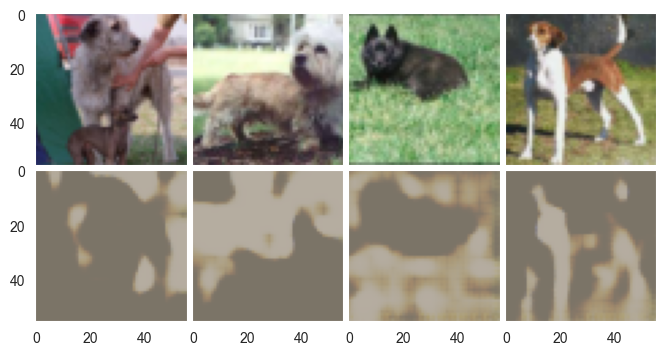

In [132]:
img, label = next(iter(valid_dl))
print(img.size(), label.size())
fig = plt.figure(1, figsize=(16, 4))
grid = ImageGrid(fig, 111, nrows_ncols=(2, 4), axes_pad=0.05)

B = torch.zeros((label.size(0), 64))
B.scatter_(1, label.unsqueeze(1), 1)
B = B.float().to(device)

x_ = net_ae(img.to(device), B)
x_ = x_.to('cpu').detach().view(-1, 3, 56, 56)
print(x_.shape)
for i in range(img.size()[0]):
    ax = grid[i]
    imshow(ax, img[i])
    ax.grid(False)
for i in range(img.size()[0]):
    ax = grid[i+4]
    imshow(ax, x_[i])
    ax.grid(False)

Видно, что оно начинает приближаться к похожим образам, контуры достаточно близкие. Как это довести до адекватного состояния я не совсем понимаю.

In [156]:
for x, lab in valid_dl:
    print(x[0].shape)
    a = x[0]
    b = x[1]
    a_l=lab[0]
    b_l = lab[1]
    break

torch.Size([3, 56, 56])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


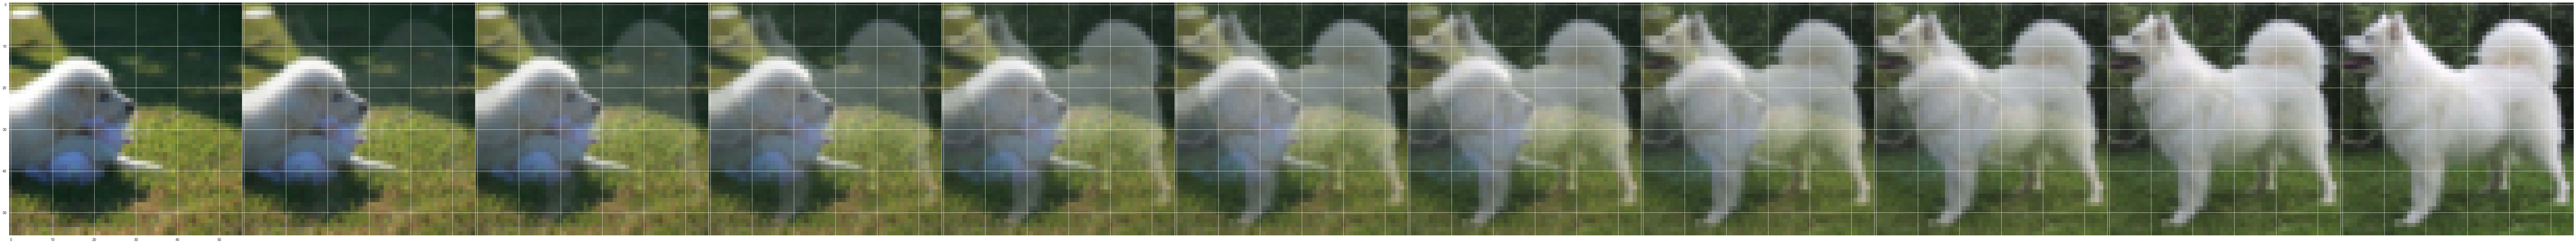

In [157]:
# pick two examples from the dataset
# a = valid_dl.dataset[i][0].view(3, 56, 56)
# print(valid_dl.dataset[i][0].shape)
# b = valid_dl.dataset[i+1][0].view(3, 56, 56)

# build a grid
fig = plt.figure(figsize=(600,50))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1")

# interpolate between images
for k in range(11):
    z = k/10. * a + (1. - k/10.) * b
    imshow(grid[k], z)
    # im = grid[k].imshow(z, interpolation="nearest")

C:\Users\BRINE\AppData\Local\Temp\ipykernel_5576\3642015641.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(a.view(1, 3, 56, 56).to(device))
C:\Users\BRINE\AppData\Local\Temp\ipykernel_5576\3642015641.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(b.view(1, 3, 56, 56).to(device))


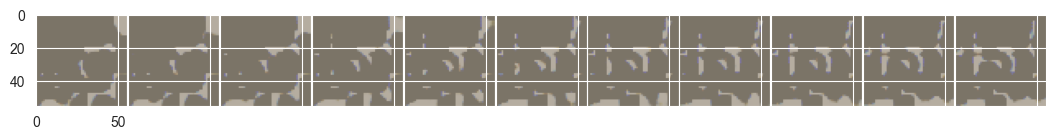

In [173]:
# get low-dimentional representations
x = torch.tensor(a.view(1, 3, 56, 56).to(device))
a_emb = net_ae.encoder(x)
x = torch.tensor(b.view(1, 3, 56, 56).to(device))
b_emb = net_ae.encoder(x)

fig = plt.figure(figsize=(60,5))
grid = AxesGrid(fig, 141, nrows_ncols=(1, 11),
                axes_pad=0.00, label_mode="1",)

for k in range(11):
    # interpolate in latent space
    z_emb = k/10. * a_emb + (1. - k/10.) * b_emb
    # use the latent code to decode the results
    A = torch.zeros(64)
    A[a_l] = 1
    A = A.float().to(device)
    B = torch.zeros(64)
    B[b_l] = 1
    B = B.float().to(device)
    A_label_embedding = net_ae.label_fc(A)
    B_label_embedding = net_ae.label_fc(B)
    Z_label_int = k/10. * A_label_embedding + (1. - k/10.) * B_label_embedding
    z_emb_ = torch.cat((z_emb.view(1, 32*7*7), Z_label_int.view(1, 64)), dim=1)
    z = net_ae.decoder(z_emb_)
    imshow(grid[k], z.cpu().data.reshape(3, 56,56))
    # im = grid[k].imshow(z.cpu().data.numpy().reshape(28,28), interpolation="nearest")

Да, понимаю, не идеально( :)))))), но какие-то очертания прослеживаются

# Task 3: Boosting the quality (2 points)

The general objective here is to boost the quality you got on the first step.
You can tune one/two more models from `torchvision` or `timm` and stack their predictions **OR** create your own CNN and use the encoder of your Autoencoder from 2nd task **OR** both.

Don't forget to compare your models properly, e.g. it's not enough to run them for only a few epochs.

Write a comment on model comparison, things and ideas that helped boost the quality, and anything else you would like to share.

В общем, честно, может я что-то где-то не услышал, но я абсолютно не понимаю, что от меня требуется в этом задании. То есть ладно, то что у меня автоэнкодер не тренируется нормально это моя проблема (хоть я и пытаюсь даже уменьшить разрешение), но что подразумевается под использованием меток классов я не понял. Как делать эту третью часть я тоже не понимаю. То есть мне нужно использовать каким-то образом классификаторную сеть для буста качества энкодера? А что с декордером делать? Тренить декодер, зеркальный резнету, это явно боль.